In [1]:
import pathlib
import multiprocessing as mproc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import timm
from mayoclinic.slide import SlideManager
from mayoclinic.predict import MayoPredictor

import warnings
from rasterio.errors import NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

In [2]:
DATA_ROOT = pathlib.Path("../../data")
DATASET_DIR = DATA_ROOT / "input/mayo-clinic-strip-ai"
TRAIN_TIFF_DIR = DATASET_DIR / "train"
TEST_TIFF_DIR = DATASET_DIR / "test"
OUTPUT_DIR = DATA_ROOT / "working"
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
N_CPUS = mproc.cpu_count()

In [3]:
train_df = pd.read_csv(DATASET_DIR / "train.csv")
test_df = pd.read_csv(DATASET_DIR / "test.csv")
slide_paths = [TRAIN_TIFF_DIR / (x + ".tif" ) for x in train_df["image_id"]]
embeddings_dir = OUTPUT_DIR / "embs"
foreground_ids_dir = OUTPUT_DIR / "fg_ids"
downscaled_dir = OUTPUT_DIR / "downscaled"

In [31]:
embeddings_dir.mkdir(parents=True, exist_ok=True)

In [4]:
CONFIG = {
    "window_yx": (512, 512),
    "bg_detection":
    {
        "tile_fg_criterion": 0.01,
        "tile_bg_brightness": 0.99,
        "block_size_factor": 0.05,
        "offset": 1,
        "erode_n_it": 2,
        "erode_kernel_size": 5
    }
}

In [5]:
slide_manager  = SlideManager(
                window_yx = CONFIG["window_yx"],
                tile_fg_criterion = CONFIG["bg_detection"]["tile_fg_criterion"],
                tile_bg_brightness = CONFIG["bg_detection"]["tile_bg_brightness"],
                slide_thresh_params = {
                    "block_size_factor": CONFIG["bg_detection"]["block_size_factor"],
                    "offset": CONFIG["bg_detection"]["offset"],
                    "erode_n_it": CONFIG["bg_detection"]["erode_n_it"],
                    "erode_kernel": np.ones([CONFIG["bg_detection"]["erode_kernel_size"]]*2)

                },
) 

In [28]:
slide_ids = []
for path in TRAIN_TIFF_DIR.glob("*.tif"):
    slide_ids.append(".".join(path.name.split(".")[:-1]))

train_df = train_df[train_df["image_id"].isin(slide_ids)]

In [ ]:
fine_model = timm.create_model('resnet10t', pretrained=True, num_classes=0)
in_imgs = torch.rand((2, 3, 1,1))

out = fine_model(in_imgs)

emb_size = out.size(1)
print("Out shape:", out.shape)
print("emb_size:", emb_size)

In [33]:
image_id = "ffec5c_1"

for _, sample in train_df.iterrows():

    slide_path = TRAIN_TIFF_DIR / (sample.image_id + ".tif")
    fg_map_path = foreground_ids_dir / (sample.image_id + ".npy")
    downscaled_path = downscaled_dir / (sample.image_id + ".npy") 

    slide_manager.new_slide(
        slide_path,
        foreground_map_path=fg_map_path,
        downscaled_path=downscaled_path,
        n_cpus=N_CPUS
    )
    
    predictor = MayoPredictor(
        slide_manager= slide_manager,
        fine_model=fine_model,
        coarse_model=None,
        batch_size=128,
        n_cpus=mproc.cpu_count(),
        device=DEVICE
    )
    
    yxs, embeddings = predictor.get_coarse_repr(slide_path, fg_map_path, downscaled_path)
    np.save(embeddings_dir / (sample.image_id + ".npy"), embeddings)

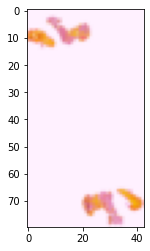

In [19]:
plt.imshow(np.moveaxis(np.load(downscaled_path), 0,-1))

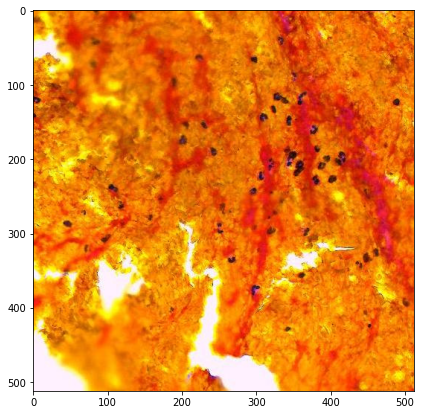

In [20]:
plt.figure(figsize=(7,7))
slide_manager.show_region(10,4)

In [22]:
predictor = MayoPredictor(
        slide_manager= slide_manager,
        fine_model=fine_model,
        coarse_model=None,
        batch_size=128,
        n_cpus=mproc.cpu_count(),
        device=DEVICE
)

In [23]:
yxs, embeddings = predictor.get_coarse_repr(slide_path, fg_map_path, downscaled_path)

In [24]:
coarse_map = predictor.coarse_lists_to_map(yxs, embeddings)

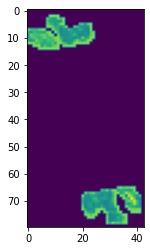

In [25]:
plt.imshow(coarse_map.mean(0).numpy())

In [32]:
np.save(embeddings_dir / (sample.image_id + ".npy"), embeddings)